In [1]:
import pandas as pd
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold, rdScaffoldNetwork
from rdkit.Chem import rdFMCS 
from rdkit import DataStructs, Chem
from scipy.spatial.distance import squareform, cdist, pdist
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles
import tmap
from faerun import Faerun
from tqdm import tqdm
from glob import glob
import os


import seaborn as sns

sns.set(style = 'white', font_scale=2)


In [2]:
def _calc_ecfp4(smiles):
    ecfp4 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smiles), radius = 2)    
    return ecfp4

def pairwise_dist_tanimoto(smiles_list):    
    MorganFP_list = [_calc_ecfp4(i) for i in smiles_list]
    TanimotoDist =[]   
    for i, fp1 in enumerate(MorganFP_list):
        for fp2 in MorganFP_list[i+1:]:
            s = DataStructs.TanimotoSimilarity(fp1,fp2)
            #Available similarity metrics include Tanimoto, Dice, 
            # Cosine, Sokal, Russel, Kulczynski, McConnaughey, and Tversky
            d = 1. - s #distance
            TanimotoDist.append(d)
    dist_matrix = squareform(TanimotoDist)

    return dist_matrix

def get_core_fw(smi):
    mol = Chem.MolFromSmiles(smi)
    core = MurckoScaffold.GetScaffoldForMol(mol)
    fw = MurckoScaffold.MakeScaffoldGeneric(core)
    return Chem.MolToSmiles(core), Chem.MolToSmiles(fw)

def get_mcs(mols):
    scd = rdFMCS.FindMCS(mols, completeRingsOnly=True,)
    sc = Chem.MolFromSmarts(scd.smartsString)
    ##get matched
    # mol = mols[0]
    # match_aidx = mol.GetSubstructMatches(sc)
    # frag = AllChem.MolFragmentToSmarts(mol, match_aidx[0])
    return sc

def plot_tmap(df, task_name, save_dir):
    
    smiles_list = df.Smiles.to_list()

    dim = 2048
    data_save_folder = save_dir
    task_name = task_name

    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,dim) for x in tqdm(mols, ascii=True)]
    ecfps = [tmap.VectorUchar(list(fp)) for fp in ECFP4_fps]
    enc = tmap.Minhash(dim,seed = 42)
    lf = tmap.LSHForest(dim)
    lf.batch_add(enc.batch_from_binary_array(ecfps))
    lf.index()

    cfg = tmap.LayoutConfiguration()
    cfg.k = 50
    cfg.kc = 50
    cfg.sl_scaling_min = 1.0
    cfg.sl_scaling_max = 1.0
    cfg.sl_repeats = 1
    cfg.sl_extra_scaling_steps = 2
    cfg.placer = tmap.Placer.Barycenter
    cfg.merger = tmap.Merger.LocalBiconnected
    cfg.merger_factor = 2.0
    cfg.merger_adjustment = 0
    cfg.fme_iterations = 150
    cfg.sl_scaling_type = tmap.ScalingType.RelativeToDesiredLength
    cfg.node_size = 1/2
    cfg.mmm_repeats = 1
    x, y, s, t, gp = tmap.layout_from_lsh_forest(lf, config = cfg)

    #======================================================
    c1 = df['pChEMBL Value'].round(3)
    c = [c1] #具体的属性数据
    series_title = ['pChEMBL Value'] ##具体的属性数据名称
    categorical = [False]
    cmap = ['jet_r']
    min_legend_label= [str(c1.min())]
    max_legend_label= [str(c1.max())]

    labels = (df.Smiles + "__" + df.index + "__" 
              + (df['Standard Value'].astype(str) + ' nM')).tolist() #显示smiles， 以及图片中的标签

    point_scale = 20
    legend_labels = [None]
    #========================================================


    faerun = Faerun(view="front", clear_color='#111111',coords=False) #'#ffffff'
    faerun.add_scatter(task_name, { "x": x, "y": y, 
                                  "c": c, "labels": labels},
                       legend_labels = legend_labels,
                       max_legend_label = max_legend_label,
                       min_legend_label = min_legend_label,
                       point_scale=point_scale,
                       colormap = cmap,
                       has_legend=True,
                       categorical = categorical,
                       series_title = series_title,
                       shader = 'smoothCircle') #"sphere", #


    faerun.add_tree(task_name + "_tree", {"from": s, "to": t}, point_helper=task_name,  color='#666666', ) #colors when no value

    # Choose the "smiles" template to display structure on hover
    faerun.plot(task_name, path = data_save_folder, template="smiles", notebook_height=750)

In [3]:
csvs = glob('./*.csv')
target_type_dict = {'mglur2': 'GPCR', 
'usp7':  'Protease',
'rip2':  'Kinase',
'phgdh':  'Other Enzyme',
'ido1':  'Other Enzyme',
'klk5':  'Protease',
'notum':  'Other Enzyme',
'plk1':  'Kinase',
'rxfp1':  'GPCR',
'braf':  'Kinase'}

In [15]:
save_dir = './info'
names = {}
infos = []
alldf = []
for csv in csvs:
    df = pd.read_csv(csv, index_col=0)
    
    csv_name = os.path.basename(csv).replace('.csv', '')
    print(csv_name)
    
    name = csv_name.lower()
    display_name = csv_name
    url_name = os.path.basename(csv)
    col_list = df.columns.tolist()
    smiles_idx = col_list.index('Smiles') + 1
    y_idx = col_list.index('pChEMBL Value') + 1
    
    # Format: name: [display_name, url_name, csv_name, smiles_idx, y_idx]
    res = {name: [display_name, url_name, csv_name, smiles_idx, y_idx]}
    names.update(res)
    #print(name, len(df), len(df1))
    #print(res)
    
    #dfs = df.Smiles.apply(get_core_fw).apply(pd.Series)
    #scaffolds = df.Smiles.apply(MurckoScaffoldSmilesFromSmiles).value_counts()

    dataset = name
    target = df['Target Name'].unique().tolist()[0]
    target_type = target_type_dict[dataset]
    inhibitors = len(df)
    reference = '; '.join(df['Document ChEMBL ID'].unique().tolist())

    info = {'dataset': dataset, 'target':target, 
            'target_type':target_type, 'size':inhibitors,
            'reference':reference}
    infos.append(info)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    plot_tmap(df, name, save_dir)
    
    df1 = df[['Standard Value', 'pChEMBL Value', 'Smiles']]
    df1['dataset'] = name
    alldf.append(df1)
    
info = pd.DataFrame(infos).sort_values('size').reset_index(drop=True)

with open(os.path.join(save_dir, 'info.md'), 'w') as f:
    info.to_markdown(f)

with open(os.path.join(save_dir, 'name.md'), 'w') as f:
    pd.DataFrame(names).to_markdown(f)

PLK1


100%|################################################################################| 73/73 [00:00<00:00, 26738.64it/s]


/home/shenwanxiang/Research/MPCD/dataset/LSSNS/info/plk1.html

/tmp/ipykernel_209784/531292962.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['dataset'] = name


RIP2


100%|################################################################################| 46/46 [00:00<00:00, 42357.41it/s]


/home/shenwanxiang/Research/MPCD/dataset/LSSNS/info/rip2.html

KLK5


100%|################################################################################| 65/65 [00:00<00:00, 48476.13it/s]


/home/shenwanxiang/Research/MPCD/dataset/LSSNS/info/klk5.html

BRAF


100%|##############################################################################| 128/128 [00:00<00:00, 41530.97it/s]


/home/shenwanxiang/Research/MPCD/dataset/LSSNS/info/braf.html

USP7


100%|################################################################################| 45/45 [00:00<00:00, 27670.97it/s]


/home/shenwanxiang/Research/MPCD/dataset/LSSNS/info/usp7.html

PHGDH


100%|################################################################################| 51/51 [00:00<00:00, 42919.24it/s]


/home/shenwanxiang/Research/MPCD/dataset/LSSNS/info/phgdh.html

Notum


100%|##############################################################################| 128/128 [00:00<00:00, 66642.37it/s]


/home/shenwanxiang/Research/MPCD/dataset/LSSNS/info/notum.html

RXFP1


100%|##############################################################################| 117/117 [00:00<00:00, 39152.19it/s]


/home/shenwanxiang/Research/MPCD/dataset/LSSNS/info/rxfp1.html

mGluR2


100%|##############################################################################| 244/244 [00:00<00:00, 38904.06it/s]


/home/shenwanxiang/Research/MPCD/dataset/LSSNS/info/mglur2.html

IDO1


100%|################################################################################| 78/78 [00:00<00:00, 56581.76it/s]


/home/shenwanxiang/Research/MPCD/dataset/LSSNS/info/ido1.html

In [28]:
dfa = pd.concat(alldf)
dfa['target'] = dfa.dataset.map(target_type_dict)
data_seq = dfa.sort_values(['target', 'dataset']).dataset.drop_duplicates().reset_index(drop=True).to_list()
md = dict(zip(data_seq, range(len(data_seq))))
md2 = {'GPCR':1, 'Kinase':2, 'Nuclear Receptor':3, 'Protease':4, 'Other Enzyme':5}

dfa['subgroup1'] = dfa.dataset.map(md)
dfa['subgroup2'] = dfa.target.map(md2)

def rtuple(x):
    d = pd.Series(x).reset_index().set_index(0)['index'].to_dict()
    return [(k, v) for k, v in d.items()]
pair_key = rtuple(md)
pair_key2 = rtuple(md2)
smiles_list = dfa.Smiles.to_list()

dim = 2048
data_save_folder = save_dir
task_name = 'LSSNS'

mols = [Chem.MolFromSmiles(s) for s in smiles_list]
ECFP4_fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,dim) for x in tqdm(mols, ascii=True)]
ecfps = [tmap.VectorUchar(list(fp)) for fp in ECFP4_fps]
enc = tmap.Minhash(dim,seed = 42)
lf = tmap.LSHForest(dim)
lf.batch_add(enc.batch_from_binary_array(ecfps))
lf.index()

cfg = tmap.LayoutConfiguration()
cfg.k = 50
cfg.kc = 50
cfg.sl_scaling_min = 1.0
cfg.sl_scaling_max = 1.0
cfg.sl_repeats = 1
cfg.sl_extra_scaling_steps = 2
cfg.placer = tmap.Placer.Barycenter
cfg.merger = tmap.Merger.LocalBiconnected
cfg.merger_factor = 2.0
cfg.merger_adjustment = 0
cfg.fme_iterations = 800
cfg.sl_scaling_type = tmap.ScalingType.RelativeToDesiredLength
cfg.node_size = 1 / 2
cfg.mmm_repeats = 1
x, y, s, t, gp = tmap.layout_from_lsh_forest(lf, config = cfg)

#======================================================
c1 = dfa['subgroup1']
c2 = dfa['pChEMBL Value'].round(3)
c3 = dfa['subgroup2']
c = [c1, c2, c3] #具体的属性数据

series_title = ['dataset', 'pIC50', 'class'] ##具体的属性数据名称
categorical = [True, False, True]
cmap = ['tab10', 'jet_r', 'Set1']
min_legend_label= [None, str(c2.min()), None]
max_legend_label= [None, str(c2.max()), None]

labels = (dfa.Smiles + "__" + dfa.index + "__" 
          + (dfa.dataset.apply(lambda x:x.upper()) + ': ' 
             + dfa['Standard Value'].astype(str) + ' nM')).tolist() #显示smiles， 以及图片中的标签

point_scale = 10

legend_labels = [pair_key, None, pair_key2]
#========================================================


faerun = Faerun(view="front", clear_color='#111111',coords=False) #'#ffffff'
faerun.add_scatter(task_name, { "x": x, "y": y, 
                              "c": c, "labels": labels},
                   legend_labels = legend_labels,
                   categorical = categorical,
                   max_legend_label = max_legend_label,
                   min_legend_label = min_legend_label,
                   point_scale=point_scale,
                   colormap = cmap,
                   has_legend=True,
                   series_title = series_title,
                   shader = 'smoothCircle') #"sphere", #

faerun.add_tree(task_name + "_tree", {"from": s, "to": t}, point_helper=task_name,  color='#666666', ) #colors when no value

# Choose the "smiles" template to display structure on hover
faerun.plot(task_name, path = data_save_folder, template="smiles", notebook_height=750)

100%|##############################################################################| 975/975 [00:00<00:00, 42029.25it/s]


/home/shenwanxiang/Research/MPCD/dataset/LSSNS/info/LSSNS.html

## by networkx

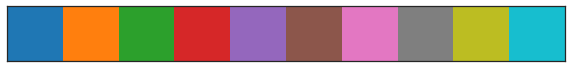

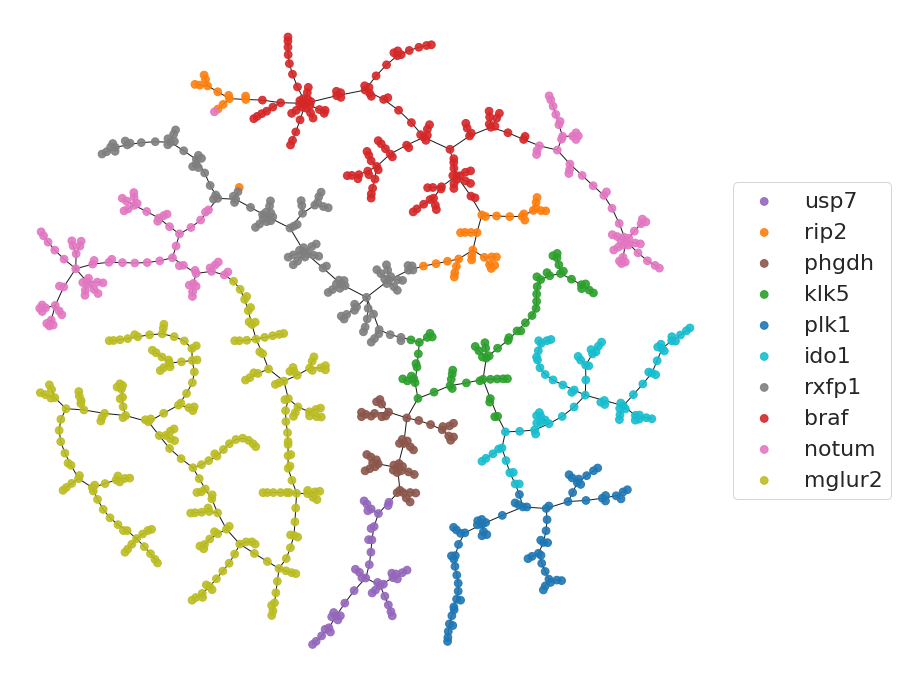

In [29]:
import networkx as nx
import matplotlib.pyplot as plt


#pos = {}
dfg = pd.DataFrame([x, y]).T
dfg.columns = ['x', 'y']
dfg['dataset'] = dfa.dataset.values
dfg.index = dfa.index
pos = {}
for i, j in dfg.iterrows():
    pos.update({i:j.loc[['x','y']].values})
    
edgelist = [(dfg.iloc[i].name,dfg.iloc[j].name) for i, j in zip(s,t)]


color = sns.color_palette("tab10", len(dfg.dataset.unique())).as_hex() #PiYG
dfg['color'] = dfg.dataset.map(dict(zip(dfg.dataset.unique(), color)))

sns.palplot(color)

fig, ax = plt.subplots(figsize=(13,10))

G = nx.Graph()

for dataset in info.dataset.to_list():
    dfg1 = dfg[dfg.dataset == dataset]
    nx.draw_networkx_nodes(G, pos=pos, node_size=60, ax = ax, alpha = 0.9,
                           nodelist=dfg1.index.values,
                           node_color=dfg1.color.values, 
                           label=dfg1.dataset.iloc[0])

nx.draw_networkx_edges(G, pos=pos, edgelist = edgelist, ax = ax, edge_color='k')

#plt.legend(loc='center')
ax.legend(scatterpoints = 1, loc='center left', bbox_to_anchor=(1, 0.5))
#ax.set_facecolor("k")


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
fig.tight_layout()

fig.savefig('./info/LSSNS.pdf', dpi = 300, bbox_inches='tight')